## Installing dependencies

 - Have python3 running on your machine
 - Create a virtual environment `python3 -m venv venv` in your current working directory
 - Enter the virtual environment `source .venv/bin/activate`, run `pip install -r requirements.txt` to install all dependencies

----



In [1170]:
import pandas as pd
import numpy as np
import matplot as mp
import random
import json
from collections import defaultdict
simulation_tick =  90
teams = []

import matplotlib.pyplot as plt

## Question 1: Temperature Modeling

Consider a scenario where the temperature X(t) varies randomly over a continuous time interval t, where t is in the range from 0 to 1. We begin with the assumption that X(0) = 0, which means that the temperature at time 0 is 0. Now, if we choose a small time increment represented by ∆t, we can make the assumption that the change in temperature from time t to t + ∆t, denoted as X(t+ ∆t)− X(t), follows a normal distribution. This normal distribution is characterized by a mean of 0 and a variance of ∆t.

1. Let $P$ be the random variable denoting the proportion of time in [0, 1] such that the temperature is positive. Estimate the distribution of $P$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)
2. Let $T_{max}$ be the random variable denoting the time in [0, 1] such that the temperature is at its maximum. Estimate the distribution of $T_{max}$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)

# Question 2: Premier League Forecasting

Create a probabilistic model and perform Monte Carlo simulations to forecast the final points for Premier League teams in the 2024-2025 season. 

This model will include some unknown parameters that you will determine based on the data you gather. 

In Premier League matches, teams earn three points for a win, one point for a draw, and no points for a loss. For your predictions, you could use statistics from the beginning of the season up to a specific date to estimate the parameters of your model, and then run Monte Carlo simulations to project the outcomes of the remaining matches, ultimately predicting the final points for each team at the season's end. 

----

Here's a brief outline of a relatively straightforward way to model this scenario. 

For each match, you can treat the number of shots attempted by the home and away teams as random variables, such as Poisson random variables. The rate parameters of the Poisson distribution will be influenced by the strengths of both teams. Each shot taken will have an associated probability of scoring, which also varies depending on the teams involved. 

You are encouraged to create your own models, but it's essential to explain and justify your choices. Discuss how you determine the parameters and outline the advantages and limitations of the models you select.

-----
## Question 2: Premier League Forecasting:

The script datascraper.py extracts a large quantity of player statistics from the website https://www.fbref.com and returnst to us a *players.json* file that we can use for our predictive model.

The general principle of our simulation is a time based simulation. I.E we start the game off with a random player from the home team (excluding the gk) taking the kick-off. When it is taken he will pass to another random player (excluding the keeper). We then simulate the players chances of either passing, shooting, keeping or losing the ball.

We need to use this data to model a large number of things:
1) Team Lineups
2) 


#### Team Lineup Creation Function:

In [1171]:
#Creates an array of the team names!
with open("./teamFormations.json", 'r') as teamFile:
        teamsJSON = json.load(teamFile)
for team in teamsJSON:
    teams.append(team['name'])

In [1172]:
class player:
    def __init__(self, name, url, pos, team, isGoalkeeper, mp, starts, gamesPlayedForCurrentTeam, startsForCurrentTeam, 
                 savePercentage, tacklesPG, interceptionsPG, shotsPG, passesPG, progPassesRecievedPG, progCarriesPG ):
        self.name = name
        self.url = url
        self.position = pos
        self.team = team
        self.isGoalkeeper = isGoalkeeper

        #Common stats:
        self.matchesPlayed = mp
        self.starts = starts
        self.gamesPlayedForCurrentTeam = gamesPlayedForCurrentTeam
        self.startsForCurrentTeam = startsForCurrentTeam

        # GK STATS:
        self.savePercentage = savePercentage

        # Outfielder Stats:
        self.tacklesPG = tacklesPG
        self.interceptionsPG = interceptionsPG
        self.shotsPG = shotsPG
        self.passesPG = passesPG
        self.progPassesRecievedPG = progPassesRecievedPG
        self.progCarriesPG = progCarriesPG
    
    def __str__(self):
        return f"[Name: {self.name}"

In [1173]:
import json
import random
from collections import defaultdict

def predict_starting_lineup(team_name, iterations=10000, file_path="./players.json"):
    """
    Predict the starting lineup for a team using a Monte Carlo simulation.

    Parameters:
        file_path (str): Path to the JSON file containing player stats.
        team_name (str): The name of the team to predict the lineup for.
        iterations (int): Number of Monte Carlo iterations.

    Returns:
        list: Predicted starting lineup as an array of player objects.
    """

    with open("./teamFormations.json", 'r') as formationFile:
        formations = json.load(formationFile)

    # Default formation
    lineup = "4,3,3"
    for formation in formations:
        if formation["name"] == team_name:
            lineup = formation["formation"]

    # Load player data from file
    with open(file_path, 'r') as file:
        players = json.load(file)

    lineup = list(map(int, lineup.split(",")))

    team_players = [player for player in players if player['team'] == team_name]

    if not team_players:
        raise ValueError(f"No players found for team {team_name}")

    # Separate players by position
    defenders = [p for p in team_players if 'DF' in p['position'].split(', ')]
    midfielders = [p for p in team_players if 'MF' in p['position'].split(', ')]
    forwards = [p for p in team_players if 'FW' in p['position'].split(', ')]
    goalkeepers = [p for p in team_players if 'GK' in p['position'].split(', ')]

    if not goalkeepers:
        raise ValueError(f"No goalkeepers found for team {team_name}")

    # Monte Carlo simulation to predict lineup
    defender_selection_counts = defaultdict(int)
    midfielder_selection_counts = defaultdict(int)
    forward_selection_counts = defaultdict(int)
    goalkeeper_selection_counts = defaultdict(int)

    for _ in range(iterations):
        selected_players = set()

        # Randomly choose players based on weights
        selected_defenders = random.choices(
            [p for p in defenders if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in defenders],
            k=min(len(defenders), lineup[0])
        )
        selected_players.update(player['name'] for player in selected_defenders)

        selected_midfielders = random.choices(
            [p for p in midfielders if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in midfielders],
            k=min(len(midfielders), lineup[1])
        )
        selected_players.update(player['name'] for player in selected_midfielders)

        selected_forwards = random.choices(
            [p for p in forwards if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in forwards],
            k=min(len(forwards), lineup[2])
        )
        selected_players.update(player['name'] for player in selected_forwards)

        selected_goalkeeper = random.choices(
            [p for p in goalkeepers if p['name'] not in selected_players],
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 0.001 for p in goalkeepers],
            k=1
        )[0]
        selected_players.add(selected_goalkeeper['name'])

        # Increment selection counts
        for player in selected_defenders:
            defender_selection_counts[player['name']] += 1
        for player in selected_midfielders:
            midfielder_selection_counts[player['name']] += 1
        for player in selected_forwards:
            forward_selection_counts[player['name']] += 1
        goalkeeper_selection_counts[selected_goalkeeper['name']] += 1

    # Determine the most likely starting lineup
    predicted_defenders = sorted(
        defender_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[0]]

    predicted_midfielders = sorted(
        midfielder_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[1]]

    predicted_forwards = sorted(
        forward_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[2]]

    predicted_goalkeeper = max(goalkeeper_selection_counts.items(), key=lambda x: x[1])

    # Aggregate all player objects into a single list
    starting_lineup = []
    selected_players = set()

    # Add goalkeeper
    starting_lineup.append(next(player for player in goalkeepers if player['name'] == predicted_goalkeeper[0]))
    selected_players.add(predicted_goalkeeper[0])

    # Add defenders
    for defender in predicted_defenders:
        player = next(player for player in defenders if player['name'] == defender[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add midfielders
    for midfielder in predicted_midfielders:
        player = next(player for player in midfielders if player['name'] == midfielder[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add forwards
    for forward in predicted_forwards:
        player = next(player for player in forwards if player['name'] == forward[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Fill remaining gaps for each position
    while len(starting_lineup) < 11:
        remaining_pool = [p for p in team_players if p['name'] not in selected_players]
        if not remaining_pool:
            break
        player = remaining_pool.pop(0)
        if len(starting_lineup) < lineup[0] + 1:  # Defenders gap
            starting_lineup.append(player)
        elif len(starting_lineup) < lineup[0] + lineup[1] + 1:  # Midfielders gap
            starting_lineup.append(player)
        else:  # Forwards gap
            starting_lineup.append(player)
        selected_players.add(player['name'])

    return starting_lineup
x = predict_starting_lineup("Manchester City")
print(x)


[{'name': 'Ederson', 'url': 'https://fbref.com/en/players/3bb7b8b4/Ederson', 'position': 'GK', 'team': 'Manchester City', 'isGoalkeeper': True, 'matchesPlayed': 334, 'savePercentage': 71.9, 'tacklesPG': 0, 'interceptionsPG': 0, 'shotsPG': 0, 'passesPG': 0, 'progPassesRecievedPG': 0, 'progCarriesPG': 0, 'starts': 333.0, 'startsForCurrentTeam': 260.0, 'gamesPlayedForCurrentTeam': 260.0}, {'name': 'Kyle Walker', 'url': 'https://fbref.com/en/players/86dd77d1/Kyle-Walker', 'position': 'DF', 'team': 'Manchester City', 'isGoalkeeper': False, 'matchesPlayed': 458, 'savePercentage': 0, 'tacklesPG': 0.47161572052401746, 'interceptionsPG': 0.4497816593886463, 'shotsPG': 0.017467248908296942, 'passesPG': 34.39301310043668, 'progPassesRecievedPG': 1.7183406113537119, 'progCarriesPG': 22.91484716157205, 'starts': 440.0, 'startsForCurrentTeam': 188.0, 'gamesPlayedForCurrentTeam': 203.0}, {'name': 'Rúben Dias', 'url': 'https://fbref.com/en/players/31c69ef1/Ruben-Dias', 'position': 'DF', 'team': 'Manch

In [1174]:

def has_shot_tick(player):
    """
    Determines if the player takes a shot during a single tick (minute) of the game.

    Parameters:
        player (dict): The player object to evaluate.

    Returns:
        bool: True if the player takes a shot during this tick, False otherwise.
    """
    # Get the player's shots per game (shotsPG)
    shots_pg = player.get("shotsPG", 0)
    
    # Calculate the probability of a shot per tick 
    shots_per_tick = shots_pg/2
    
    # Generate a random number between 0 and 1
    probability = random.uniform(0, 1)
    
    # Compare the random number to shotsPerTick (treated as the weight)
    return probability < shots_per_tick


In [1175]:

def has_pass_tick(player):
    """
    Determines if the player makes a pass during a single tick (minute) of the game.

    Parameters:
        player (dict): The player object to evaluate.

    Returns:
        bool: True if the player makes a pass during this tick, False otherwise.
    """
    # Get the player's passes per game (passesPG)
    passes_pg = player.get("passesPG", 0)
    
    # Calculate the probability of a pass per tick 
    passes_per_tick = passes_pg/2 
    
    # Generate a random number between 0 and 1
    probability = random.uniform(0, 1)
    
    # Compare the random number to passesPerTick (treated as the weight)
    return probability < passes_per_tick


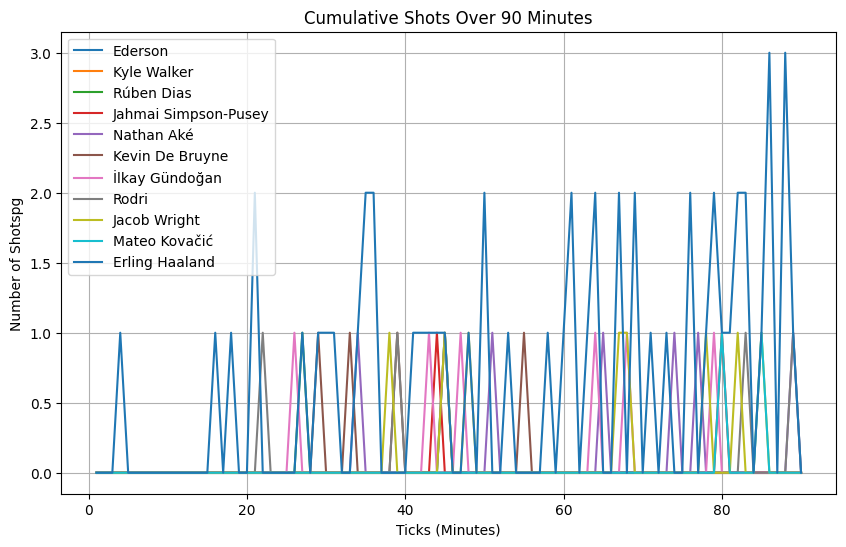

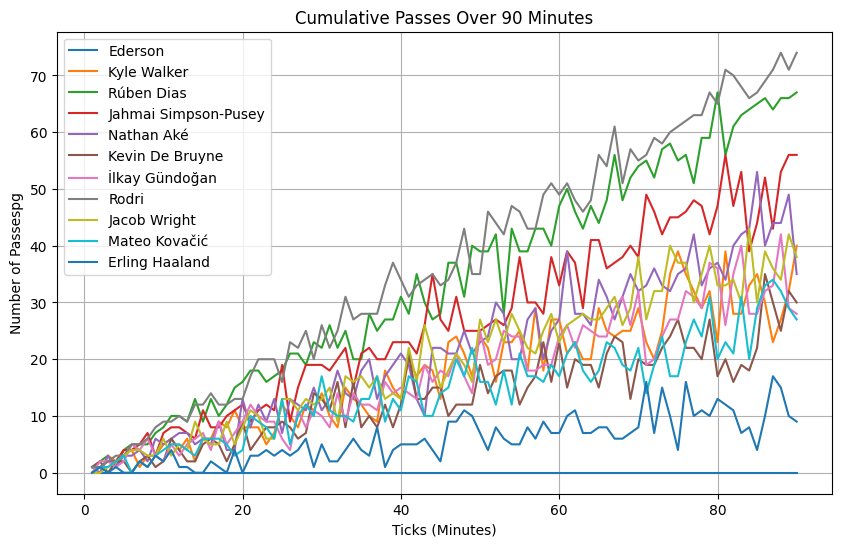

In [1176]:
def has_event_tick(player, stat_name):
    """
    Determines if the player performs an action (e.g., shot or pass) during a single tick.

    Parameters:
        player (dict): The player object to evaluate.
        stat_name (str): The stat to base the event probability on (e.g., "shotsPG" or "passesPG").

    Returns:
        bool: True if the player performs the action during this tick, False otherwise.
    """
    stat_value = player.get(stat_name, 0)
    stat_per_tick = stat_value / 90  # Probability per tick
    return random.uniform(0, 1) < stat_per_tick

def simulate_and_plot(players, stat_name, title):
    """
    Simulates events for multiple players over 90 ticks and plots the results.

    Parameters:
        players (list): List of player objects.
        stat_name (str): The stat to simulate (e.g., "shotsPG" or "passesPG").
        title (str): Title for the graph.
    """
    results = {player['name']: [] for player in players}

    # Simulate events for each player over 90 ticks
    for player in players:
        for tick in range(1, simulation_tick + 1):
            result = sum(has_event_tick(player, stat_name) for _ in range(tick))
            results[player['name']].append(result)

    # Plot the data
    plt.figure(figsize=(10, 6))
    for player_name, events in results.items():
        plt.plot(range(1, simulation_tick + 1), events, label=player_name)

    # Add graph details
    plt.title(title)
    plt.xlabel("Ticks (Minutes)")
    plt.ylabel(f"Number of {stat_name.capitalize()}")
    plt.legend()
    plt.grid()
    plt.show()
    
# Simulate and plot shots
simulate_and_plot(x, "shotsPG", "Cumulative Shots Over 90 Minutes")

# Simulate and plot passes
simulate_and_plot(x, "passesPG", "Cumulative Passes Over 90 Minutes")